In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import math
import gzip
from plotly import express as px
from scipy.optimize import curve_fit

# Data Exploratory Analysis

## domain score

In [10]:
domain_score = pd.read_csv("domains_ideology_score_LADA.txt", delimiter = "\t", header=None)
"""
obtained from Bakshy et al, 
removed a few domains that are not owned by news organizations (e.g., wikipedia.org or reddit.com), 
and added shortened versions of news domains to the list (e.g. fxn.ws for foxnews.com).
"""

# data cleaning
domain_score = domain_score.rename(columns={
    0: "domain",
    1: "score"
})

# check result
domain_score.head(5)
# score close to 1: conservative
# score close to 0: liberal

,domain,score
0,weaselzippers.us,1.00
1,vote.gop,1.00
2,tedcruz.org,1.00
3,donaldjtrump.com,1.00
4,billoreilly.com,0.99


some plot to help us understand this data

In [27]:
# The distribution of the domains:
# fig, ax = plt.subplots(1,1)
px.histogram(domain_score,
             x="score",
             color = "domain",
             opacity = 0.5,
             nbins = 20,
             barmode='stack')

We sampled some websites from each bin of score, and checked the score's validity.

In [55]:
print('Count of liberal domains assume neutral=(0.35,0.65): ' + str((domain_score[domain_score["score"]<=0.35]).count()[1]))
print('Count of liberal domains assume neutral=(0.45,0.55): ' + str((domain_score[domain_score["score"]<=0.45]).count()[1]))

Count of liberal domains assume neutral=(0.35,0.65): 177
Count of liberal domains assume neutral=(0.45,0.55): 251


In [57]:
print('Count of liberal domains assume neutral=(0.35,0.65): ' + str((domain_score[domain_score["score"]>=0.65]).count()[1]))
print('Count of liberal domains assume neutral=(0.45,0.55): ' + str((domain_score[domain_score["score"]>=0.55]).count()[1]))

Count of liberal domains assume neutral=(0.35,0.65): 176
Count of liberal domains assume neutral=(0.45,0.55): 205


From the plot and chart above, we can tell that the domains from each side of the polarity have similar sample sizes. 

However, the liberal domains tend to be more evenly spreaded from neutral to extreme, while the conservative domains tend to be more concentrated for scores greater than 0.92.

It also seems like there are 2 skewed Gaussian curves:

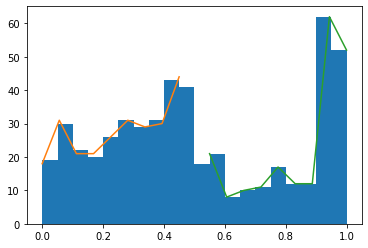

In [93]:
plt.hist(domain_score['score'], bins=20, density=False)

mean_lib = domain_score[domain_score["score"]<=0.45].mean()[0]
mean_con = domain_score[domain_score["score"]>=0.55].mean()[0]

std_lib = domain_score[domain_score["score"]<=0.45].std()[0]
std_con = domain_score[domain_score["score"]>=0.55].std()[0]

x_lib = np.linspace(0, 0.45, 9)
x_con = np.linspace(0.55, 1, 9)

ranges = np.linspace(0,1,21) 
y_lib = domain_score.score.groupby(pd.cut(domain_score.score, ranges)).count()[:9].to_list()
y_con = domain_score.score.groupby(pd.cut(domain_score.score, ranges)).count()[11:].to_list()
# plt.plot(x_lib, y_lib)
# plt.plot(x_con, y_con)

In [97]:
def gaus(x,a,x0,sigma):
    return a* np.exp(-(x-x0)**2/(2*sigma**2))

popt,pcov = curve_fit(gaus,x_lib,y_lib,p0=[1,mean_lib,std_lib])

plt.plot(x_lib,gaus(x_lib,*popt))

# faile to fit gaussian curve: I think there's too few counts

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

The liberal domains seem to skew towards the center of the scale, and the conservative domains seem to skew towards the edge.

## User Polarity

In [11]:
user_polarity = pd.read_csv("USER_POLARITY_BARBERA.txt", delimiter = "\t", header=None)
user_polarity = user_polarity.drop([2], axis=1)
user_polarity.head(5)

,0,1
0,100005598,-2.064026
1,100091223,1.864350
2,10012122,0.424817
3,100122730,1.922963
4,100250921,1.808188


Why is polarity not bounded by 1??

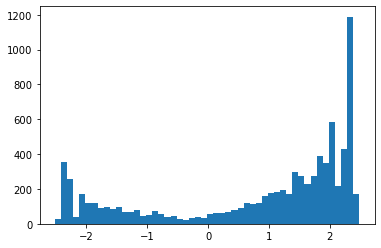

In [104]:
fig = plt.hist(user_polarity[1], bins=50, density=False)

We can tell that the users are very polarized, expecially towards the positive numbers.

We wish to further investigate this graph once we understand how it's calculated (i.e. why is it not bounded by 1).

## user info

In [107]:
obamacare_userinfo = pd.read_csv("obamacare/userinfo.txt", 
                                 delimiter = "\t", 
                                 header = None, 
                                 lineterminator='\n')

"""
dataset obtained using Archive Twitter Stream grab
"""
obamacare_userinfo = obamacare_userinfo.rename(columns={
    0:  "user_ID",
    1:  "twitter_ID",
    2:  "handle_name",
    3:  "location",     # self-reported
    4:  "bio",
    5:  "followers",    # my speculation
    6:  "following",    # my speculation
    7:  "num_tweets",
    8:  "date",
    11: "language",
    13: "external_link",
    16: "profile_pic"
})

# I think column 14 and 15 are empty, there are just multiple tabs between urls
# and after the following code, I double checked the source file

# obamacare_userinfo[obamacare_userinfo[14].notna()]
# obamacare_userinfo[obamacare_userinfo[15].notna()]

obamacare_userinfo = obamacare_userinfo.drop([14, 15], axis=1)

In [108]:
obamacare_userinfo.head(5)

,user_ID,twitter_ID,handle_name,location,bio,followers,following,num_tweets,date,9,10,language,12,external_link,profile_pic
0,334537201,00_jackie,Jackie ️,♥•♥ Oklahoma ♥•♥,"Saved sinner, Conservative, pro Israel, pro Mi...",6115,1041,39411,Wed Jul 13 07:48:53 +0000 2011,False,False,en,False,https://t.co/dMTSML3qwc,http://pbs.twimg.com/profile_images/6095617438...
1,115094250,0103lrl,Larry Lawson (D),NaN,"Progressive Democrat! We're wounded, but not d...",5534,5358,177943,Wed Feb 17 15:57:36 +0000 2010,False,False,en,True,NaN,http://pbs.twimg.com/profile_images/8450958772...
2,2369916919,055Douglas,🔴 Douglas 🔴,NaN,"I enjoy music, warm weather, gardening. Workin...",5038,4762,46476,Mon Mar 03 05:36:02 +0000 2014,False,False,en,True,NaN,http://pbs.twimg.com/profile_images/8934867018...
3,1146470090,100Concerned,endure,NaN,"photography,music, travel, nature,do not buy f...",2015,2358,179716,Sun Feb 03 23:04:27 +0000 2013,False,False,en,True,NaN,http://pbs.twimg.com/profile_images/3788000007...
4,95708744,100Natural,100%Natural,México,Grupo de Franquicias de Restaurantes que promu...,2198,362,14554,Wed Dec 09 19:01:12 +0000 2009,False,False,es,True,http://t.co/smkBBf2sLc,http://pbs.twimg.com/profile_images/9143582449...


In [177]:
user_lan = obamacare_userinfo.groupby("language")["language"].count().sort_values()
user_lan

language
el          1
gl          1
nl          1
es-MX       2
id          2
ru          3
de          5
fr          7
pt          7
it          8
en-gb      10
ca         23
es       1015
en       7650
Name: language, dtype: int64

In [180]:
# percentage of language speakers
user_lan / user_lan.sum() * 100

language
el        0.011448
gl        0.011448
nl        0.011448
es-MX     0.022896
id        0.022896
ru        0.034345
de        0.057241
fr        0.080137
pt        0.080137
it        0.091586
en-gb     0.114482
ca        0.263309
es       11.619920
en       87.578706
Name: language, dtype: float64

It seems like the majority of these users post in English, and the second majority post in Spanish. Let's look into these two groups:

In [139]:
userinfo_en_es = obamacare_userinfo[(obamacare_userinfo["language"]=="en") | (obamacare_userinfo["language"]=="es")]

In [145]:
fig = px.scatter(data_frame = userinfo_en_es,
                x = "followers",
                y = "following", 
                opacity = 0.5, 
                facet_col = "language",
                hover_name="twitter_ID")
fig.show()

For people who post in English, there are 3 outliers that have relatively large amount of Followers (and it makes sense cuz these 3 people are Barack Obama, Justin Bieber, and The Ellen Show). 1 outlier has relatively large amount of Following (BraveLad).\
\
For people who post in Spanish, there is 1 outlier (RoyCampos) that has relatively large amount of Following.

In [152]:
# get rid of the outliers
outliers = ["BarackObama", "justinbieber", "TheEllenShow", "BraveLad", "RoyCampos"]
fig = px.scatter(data_frame = userinfo_en_es[np.isin(userinfo_en_es["twitter_ID"], 
                                                     outliers,
                                                     invert=True)],
                x = "followers",
                y = "following", 
                opacity = 0.5, 
                facet_col = "language",
                hover_name="twitter_ID")
fig.show()

The two groups seem to have similar distribution, taking into account of the sample size difference.

Let's zoom in closer:

In [174]:
# we wish to get rid of ppl with tons of followers: 
# let's see how many we're filtering
userinfo_en_es[userinfo_en_es["followers"] >= 15000000].user_ID.count()
# 21 doesn't seem too bad

21

In [173]:
userinfo_en_es[userinfo_en_es["following"] >= 150000].user_ID.count()

30

In [176]:
fig = px.scatter(data_frame = userinfo_en_es[(userinfo_en_es["followers"] < 15000000) & (userinfo_en_es["following"] < 150000)],
                x = "followers",
                y = "following", 
                opacity = 0.2, 
                facet_col = "language",
                hover_name="twitter_ID")
fig.show()

## production score

In [52]:
user_production_score = pd.read_csv("obamacare/users_production_scores.txt", delimiter = "\t", header = None, lineterminator='\n')

In [57]:
user_production_score = user_production_score.rename(columns={
    0: "user_ID"
})

In [58]:
user_production_score

,user_ID,1,2,3
0,334537201,0.734128,0.223540,391.0
1,115094250,0.226682,0.152557,294.0
2,2369916919,0.288123,0.183243,160.0
3,1146470090,0.305678,0.169161,517.0
4,95708744,0.347375,0.000000,1.0
...,...,...,...,...
8614,1231303752,0.632540,0.253130,87.0
8615,14622223,0.399442,0.082604,928.0
8616,57134276,0.301048,0.095428,594.0
8617,327715590,0.745652,0.220540,104.0


## tweets

In [35]:
def prepare_df(df):
    df = df.rename(columns={
    0:  "user_ID",
    1:  "tweet_ID",
    2:  "tweet_content",
    3:  "date",
    4:  "tweet_link",
    5:  "likes",        # my speculation
    6:  "comments",     # my speculation
    7:  "retweets"      # my speculation
})
"""
some problem I was thinking about: 
1.  all of the data need to be in memory at the same time,
    thus even if we create a database by chunk, it is still hard to do the ML part
    
2.  then i was thinking about a way to process them by chunk:
    can we implement the algorithm by hand, then process them by chunk?
    
3.  the problem with implementing algorithm by hand: 
        I did it for my MATH156 class, and it was extremely slow compared to scikit-learn
        
despite the problems, I still implemented the code to create a database by chunks
in case we'll need it
"""

import sqlite3
conn = sqlite3.connect("obama.db") 
df_iter = pd.read_csv("obamacare/USER_TWEETS.txt", 
                      delimiter = "\t", 
                      header = None, 
                      lineterminator='\n',
                      chunksize = 100000)
for df in df_iter:
    df = prepare_df(df)
    df.to_sql("tweets", conn, if_exists = "append", index = False)

In [36]:
obamacare_tweets = pd.read_csv("obamacare/USER_TWEETS.txt.gz", compression = "gzip",
                               delimiter = "\t", header = None, lineterminator = "\n",
                                error_bad_lines=False, nrows=1000000)


obamacare_tweets

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,334537201,917247622502584320,@AZWS @GovMaryFallin Hi 👋🏼 Yes it has. Thank y...,Mon Oct 09 04:37:29 +0000 2017,"<a href=""http://twitter.com/download/iphone"" r...",1,N,0,NaN,NaN,AZWS GovMaryFallin,N,NaN,NaN
1,334537201,917246099190140929,RT @redsteeze: Where is Donald Trump from agai...,Mon Oct 09 04:31:26 +0000 2017,"<a href=""http://twitter.com/download/iphone"" r...",898,N,0,NaN,https://t.co/9uTcmCyRD5--a0a--https://twitter....,redsteeze,N,NaN,NaN
2,334537201,917245534288728064,#douchebag @Kaepernick7 👈🏼 https://t.co/ttu8oY...,Mon Oct 09 04:29:11 +0000 2017,"<a href=""http://twitter.com/download/iphone"" r...",0,N,0,douchebag,https://t.co/ttu8oYFldA--a0a--https://twitter....,Kaepernick7,N,NaN,NaN
3,334537201,917244832166371328,RT @chuckwoolery: Health Insurers in FL Reques...,Mon Oct 09 04:26:24 +0000 2017,"<a href=""http://twitter.com/download/iphone"" r...",355,N,0,NaN,https://t.co/ndlI4KkHF6--a0a--https://bluntfor...,chuckwoolery,N,NaN,NaN
4,334537201,917244447615799296,RT @MarkYoungTruth: Working on my resume’ for ...,Mon Oct 09 04:24:52 +0000 2017,"<a href=""http://twitter.com/download/iphone"" r...",91,N,0,bluntforcetruth,NaN,MarkYoungTruth,N,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,1357799989,871983133243179008,Desde el fondo de mi ❤️...,Tue Jun 06 06:52:34 +0000 2017,"<a href=""http://twitter.com/#!/download/ipad"" ...",0,N,0,NaN,NaN,NaN,N,NaN,NaN
999996,1357799989,871982661149044736,RT @UHumanitas: Siempre proponte ir cuesta arr...,Tue Jun 06 06:50:41 +0000 2017,"<a href=""http://twitter.com/#!/download/ipad"" ...",983,N,0,NaN,NaN,UHumanitas,N,NaN,NaN
999997,1357799989,871982263096967168,@Iovintit Perdón estaba hablando de negocios h...,Tue Jun 06 06:49:06 +0000 2017,"<a href=""http://twitter.com/#!/download/ipad"" ...",0,N,0,NaN,NaN,NaN,N,NaN,NaN
999998,1357799989,871981424244641793,Gloria trevi Versus Tour //Me hubiera gustado ...,Tue Jun 06 06:45:46 +0000 2017,"<a href=""http://twitter.com/#!/download/ipad"" ...",0,N,0,NaN,https://t.co/d776AaX7Xx--a0a--https://youtu.be...,NaN,N,NaN,NaN


In [44]:
obamacare_tweets.loc[1000][2]

'RT @badov49: REPORT: Anti-Trump Senator Mark Warner Made $6 Million in 2012 From Russian Tech Business https://t.co/YZ7WZvYXHk'

## networks

In [2]:
networks = pd.read_csv("obamacare/FULL_FOLLOWER_NETWORK.txt.gz", compression = "gzip",
                               delimiter = "\t", header = None, lineterminator = "\n",
                                error_bad_lines=False)

In [16]:
networks.head(6000)

,0,1
0,334537201,2652830652
1,334537201,31623445
2,334537201,907991059694792704
3,334537201,709158721746804737
4,334537201,1623194148
...,...,...
5995,334537201,84062050
5996,334537201,186618551
5997,334537201,27427649
5998,334537201,325739781
